# Regression Analysis of the Hotel Customer Dataset
**Evamaria Saunders** <br>
**28/11/2021** <br>
**Dataset**: https://www.kaggle.com/nantonio/a-hotels-customers-dataset?resource=download <br>
*More Information*: https://www.sciencedirect.com/science/article/pii/S2352340920314645?via%3Dihub <br>

<br>

## Part 1: Pre-Processing

In [1]:
#import relevant libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
plt.style.use("seaborn")

In [2]:
#settings for displaying tables/dataframes
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [3]:
file_dir = "C:/Users/Computer/Documents/Evamaria's Documents/Personal Projects/Data/HotelCustomersDataset.xlsx"
dataset = pd.read_excel(file_dir)

### Part 1.1: Missing Values
In this case, the only variable with obvious missing values is Age. After further exploration, there might be an underlying pattern that distinguishes customers with and without a reported age. Most notably, there are some differences in terms of the Days Since Creation and the Lodging Revenue. At this point, it is unclear whether there is any truth to this pattern or if missing age values are not systematic after all. In general, less than 5% of age values are missing. Based on this, two options are possible: (1) due to the relatively small number of affected customers, exclude these cases under the assumption that there is no systematic reason behind this and that future analyses will not be negatively affected by excluding said customers; or (2) use a systematic manner of replacing said missing values, for instance kNN. For the next parts, no decision will be made on this matter. 

In [4]:
#explore which variables have missing values
dataset.isnull().apply(lambda x:x.value_counts())

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
False,83590.0,83590.0,79811,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,...,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0
True,NaN,NaN,3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#explore whether customers with missing values for age are different from other customers
dataset[dataset["Age"].isnull()].describe()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,3779.000000,0.0,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,...,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.0,3779.000000,3779.0,3779.000000
mean,30564.220164,NaN,604.807356,53.236306,227.895337,59.834678,0.005822,0.001852,0.829849,3.609950,...,0.000794,0.001323,0.000265,0.009791,0.254035,0.123842,0.0,0.002117,0.0,0.035194
std,23879.422399,NaN,332.874209,81.668457,457.564384,145.264834,0.082753,0.048773,0.799615,3.993015,...,0.028168,0.036355,0.016267,0.098477,0.435375,0.329445,0.0,0.045968,0.0,0.184295
min,2.000000,NaN,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,8717.500000,NaN,288.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,25658.000000,NaN,633.000000,13.000000,144.500000,27.000000,0.000000,0.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
75%,49072.500000,NaN,922.000000,76.000000,295.500000,68.500000,0.000000,0.000000,1.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000
max,83536.000000,NaN,1095.000000,588.000000,21781.000000,5105.500000,2.000000,2.000000,29.000000,62.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000


In [6]:
dataset[dataset["Age"].notnull()].describe()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,...,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000
mean,42327.293944,45.398028,446.483267,66.809663,302.159477,67.956300,0.001842,0.000576,0.792948,4.698337,...,0.000877,0.002919,0.001779,0.013382,0.357357,0.143426,0.000351,0.003571,0.000125,0.090890
std,24012.564901,16.572368,310.620996,87.990086,368.022975,112.640373,0.065912,0.028312,0.690435,4.587289,...,0.029603,0.053953,0.042143,0.114903,0.479224,0.350509,0.018727,0.059651,0.011193,0.287454
min,1.000000,-11.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21680.500000,34.000000,174.000000,0.000000,64.000000,2.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42383.000000,46.000000,385.000000,30.000000,236.000000,39.800000,0.000000,0.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,63194.500000,57.000000,703.000000,104.000000,407.000000,88.500000,0.000000,0.000000,1.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,83590.000000,122.000000,1095.000000,588.000000,9682.400000,7730.250000,9.000000,3.000000,66.000000,116.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


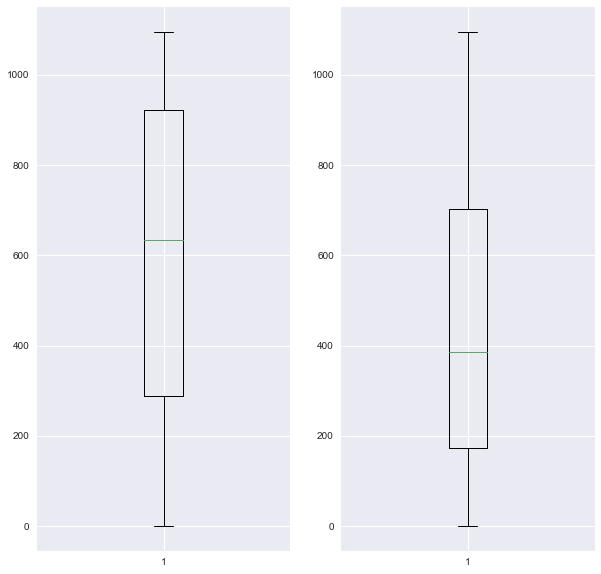

In [7]:
#difference in Days Since Creation
figure, axis = plt.subplots(1,2, figsize=(10,10))
axis[0].boxplot(dataset["DaysSinceCreation"][dataset["Age"].isnull()])
axis[1].boxplot(dataset["DaysSinceCreation"][dataset["Age"].notnull()])
plt.show()

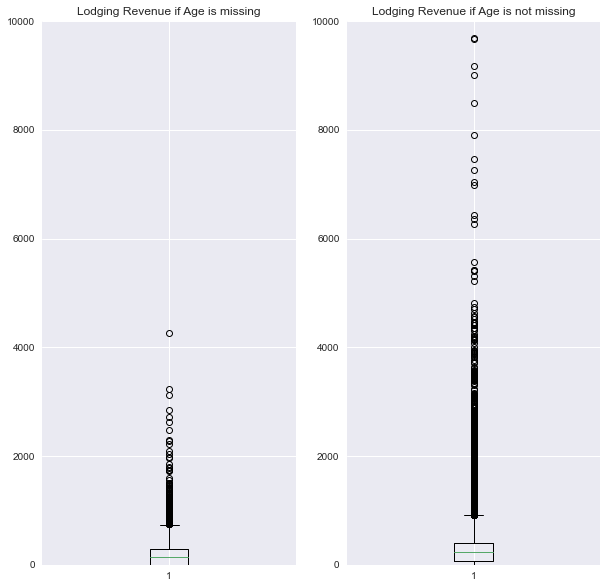

In [8]:
#Difference in Lodging Revevenue (after excluding one major outlier)
figure, axis = plt.subplots(1,2, figsize=(10,10))
axis[0].boxplot(dataset["LodgingRevenue"][dataset["Age"].isnull()])
axis[0].set_ylim(0,10000)
axis[0].set_title("Lodging Revenue if Age is missing")

axis[1].boxplot(dataset["LodgingRevenue"][dataset["Age"].notnull()])
axis[1].set_ylim(0,10000)
axis[1].set_title("Lodging Revenue if Age is not missing")

plt.show()

In [9]:
#how often is Age missing among customers that never completed a booking?
print(dataset["Age"][(dataset["BookingsCanceled"] == 0) & (dataset["BookingsNoShowed"] == 0) & (dataset["BookingsCheckedIn"] == 0)].isnull().value_counts())

#how often is Age missing among customers that completed at least one booking?
print(dataset["Age"][(dataset["BookingsCanceled"] > 0) | (dataset["BookingsNoShowed"] > 0) | (dataset["BookingsCheckedIn"] > 0)].isnull().value_counts())

False    19070
True       849
Name: Age, dtype: int64
False    60741
True      2930
Name: Age, dtype: int64


### Part 1.2: Outliers
Examing the different variables, both outliers based on which values are meaningful as well as based on statistical criteria could be identified. The criteria used to consider values as outliers is 3SD above (or below) the mean. 

Firstly, there are several customers with a negative value for age. As this value is often below 10, it seems unlikely that the minus was a mistake. These customers will be excluded. 
Moreover, there are several customers with age above 100 years. As very few individuals reach this age and no one over the age of 118 has been recorded in the last century, these age values certainly extreme and possibly false and these customers will be excluded. 

Secondly, for 19920 customers the Days Since Last and First Stay has the value -1. It appears that this was used to mark customers that never completed a booking. 

Thirdly, for ten customers the average lead time was below -1. This could represent a missing value. Since only so few customers are missing, exclusion or filling in the missing values are the two easiest solutions. In contrast, the large number of customers with a rather large average lead time are harder to deal with. As the distribution of these customers is rather uniform, determining which ones to exclude is difficult.

Forthly, there are certainly several outliers for the three booking outcome variables. As these three variables could be considered unary variables, the outliers and general issue will be dealt with as follows: create two new variables, namely a categorial BookingsCheckedIn ("None", "One", "More than One") and a boolean OtherOutcome("Cancelled/NoShow" - True/False).

Fifthly, for both types of revenue customers above a specified value will be excluded as their extreme outliers might skew the data too much. These values were chosen based on the graphs and are as follows: 5000 for lodging revenue, and 2000 for other revenue. 

Sixtly, in a similar fashion several customers will be excluded based on extremely high values for Room Nights or Persons Nights, specifically above 30 and 40, respectively. 

For the remaining variables, no outliers were detected. 

In [10]:
#examine the least common nationality values to see if there are possible outliers
dataset["Nationality"].value_counts()[-25:]

TMP    1
TZA    1
FJI    1
TON    1
MRT    1
      ..
FRO    1
DMA    1
NPL    1
NRU    1
PCN    1
Name: Nationality, Length: 25, dtype: int64

In [11]:
#explore age outliers
dataset[(dataset["Age"] < 0) | (dataset["Age"] > (3 * dataset["Age"].std() + dataset["Age"].mean()))]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
2053,2054,BIH,-7.0,1034,0x816353557EFCF6A1E3FF64F3D652A18AE9F7EC0011E3...,0xE2B44FF02C72B0234AFA04D4BA9C7889491F302A9963...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2469,2470,ATF,-7.0,1029,0x05640BCB4A2D55CFDB6FB9615FD588A68C333119BC5F...,0x169E79749C1DD48C3510BEDBC69DD0DC9E0BDEF72B9C...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3282,3283,PRT,114.0,1015,0xD38D7A36180C13A0574D7519E1494B8E2EAC72621A6D...,0xCF11B7A6F80F424EDB78D3FF8352233D36F6F511F9B6...,22,79.0,25.5,0,...,0,0,0,0,1,0,0,0,0,0
5128,5129,FRA,-9.0,981,0x6471098D9873D3D9CE70D2456C07F63B3359B270A5DE...,0x28EE0D2DD37EC913224737D542F8B9B6F30794306710...,66,93.3,14.0,0,...,0,0,0,0,1,0,0,0,0,0
6751,6752,GBR,-11.0,953,0xDB672419DADD95C4603D3210DCD2722B008DEBD1C69F...,0xB8599D349F3951EF4D29B6F03E4EB0E22ADEC4105246...,22,450.0,18.0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53284,53285,ITA,122.0,253,0xE03325073EB006F0486B5D31DDBE755ACCA2E25EBF6F...,0x3857EEF67D85FED04558802533FE4045E4E435401FF1...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
57342,57343,PRT,-6.0,220,0xE327757DEF4F79D6ABAA08E002F7C88789B121BC2C59...,0x6EB53E609C77B04F0A2F6D9C9F16C5D10969CCF77F6B...,130,388.8,47.2,0,...,0,0,0,0,0,0,0,0,0,0
58036,58037,AUT,113.0,213,0xC00F5FF79E457FCD954A52BC4D32B183551563B74950...,0x78CFDBB1FE8B477F39FBF5AAE40712F99693C3285D86...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
62677,62678,NOR,96.0,177,0x50D3ABACF8477867E7B1ECADEF10CCCB42677B6C6BA4...,0xF0711CD1224E387B88663604CB8B2301DD7091FFA3A2...,87,734.0,24.0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
#customers with values below 0
print((dataset["DaysSinceCreation"] < 0).value_counts())
print((dataset["DaysSinceLastStay"] < 0).value_counts())
print((dataset["DaysSinceFirstStay"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["DaysSinceCreation"][dataset["DaysSinceCreation"] > (3 * dataset["DaysSinceCreation"].std() + dataset["DaysSinceCreation"].mean())]))
print(len(dataset["DaysSinceFirstStay"][dataset["DaysSinceFirstStay"] > (3 * dataset["DaysSinceFirstStay"].std() + dataset["DaysSinceFirstStay"].mean())]))
print(len(dataset["DaysSinceFirstStay"][dataset["DaysSinceFirstStay"] > (3 * dataset["DaysSinceFirstStay"].std() + dataset["DaysSinceFirstStay"].mean())]))

False    83590
Name: DaysSinceCreation, dtype: int64
False    63670
True     19920
Name: DaysSinceLastStay, dtype: int64
False    63670
True     19920
Name: DaysSinceFirstStay, dtype: int64
0
0
0


In [13]:
#customers with values below 0
print((dataset["AverageLeadTime"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["AverageLeadTime"][dataset["AverageLeadTime"] > (3 * dataset["AverageLeadTime"].std() + dataset["AverageLeadTime"].mean())]))

False    83580
True        10
Name: AverageLeadTime, dtype: int64
1379


In [14]:
dataset[dataset["AverageLeadTime"] < 0]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
23061,23062,PRT,NaN,674,0x950528CDB64433021300E90F82F0A488EE3D77975107...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,-1,352.00,30.0,0,...,0,0,0,0,0,0,0,0,0,0
29370,29371,USA,24.0,580,0x45F7145C9756209F4516792A12405BCF80F0CA11C9DA...,0xBF7D0F7A307408DB6DF379DA51FCDD3CDE4BED55949B...,-1,77.49,3.0,0,...,0,0,0,0,0,0,0,0,0,0
51361,51362,CHN,32.0,268,0x1F272F052D5331199FA42B15CC3D61673248B3681AA5...,0xFEE3773458B225FE3801DCAE2A05B6555CBF3189BA6F...,-1,129.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0
58639,58640,FRA,56.0,209,0xA9B2F0B5565363E5139FAB8B334CFAD53B6A4AA2C288...,0x9A65F4E43F686D03748C3D7A4B67E2147D0FE258C876...,-1,149.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0
58646,58647,FRA,61.0,209,0x540543AB2CF737FA79CFF44288F339AD315418CA45B3...,0x6C029B2137E29E837182F75AE1A4E75C8362FB29F8DC...,-1,149.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0
58660,58661,FRA,60.0,209,0xAC235F8012A830A8C10F2A5B2F0768B3A31FF909E99C...,0x5DD2CFBC8B0458DB9810532AE49BD01082D14704FC40...,-1,149.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0
60574,60575,ESP,45.0,195,0xE78ACF1238CDD93FE7F7427757C35B109E7477D87A1B...,0x41A4B91A984EB68C9D465F184A5C8EBB2196E7DF5B77...,-1,159.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0
62673,62674,USA,69.0,178,0x80E6939CD6CB5B0150D97670C19F4CAD17D9283944EC...,0x4EF4596897E1BA99E3B28B0FF8A67E86F87CC0E8FEA3...,-1,95.20,2.0,0,...,0,0,0,0,0,0,0,0,0,0
68469,68470,GBR,45.0,134,0x53A6D7D4B9E9799A8CBE5F05E83BEDC9673838DA4A5E...,0xF546FA5913D1B0AC53428DFCEC5E5AEE1CC45F55C252...,-1,282.00,24.0,0,...,0,0,0,0,0,0,0,0,0,0
72692,72693,BRA,30.0,104,0xBA8138E4B688037A2DCC39759960D57D6A633E5941F7...,0xE9C4A25F17D1199C2B82249C09C6201E67ABBBDA4439...,-1,209.00,2.0,0,...,0,0,0,0,0,0,0,0,0,0


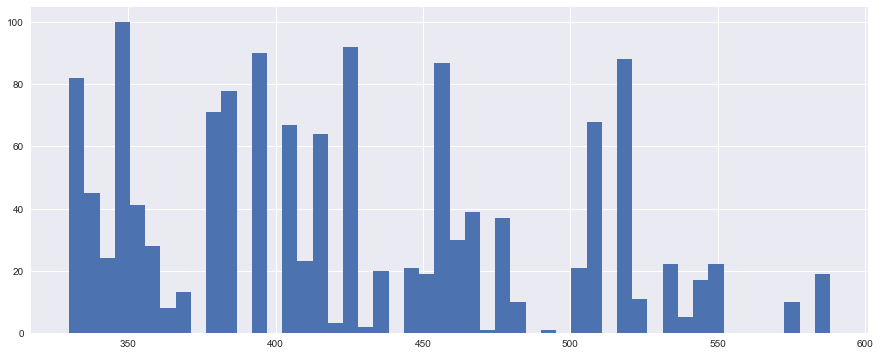

In [15]:
#visualising the distributions of AverageLeadTime for these customers
plt.figure(figsize = (15,6))
plt.hist(dataset["AverageLeadTime"][dataset["AverageLeadTime"] > (3 * dataset["AverageLeadTime"].std() + dataset["AverageLeadTime"].mean())],50)
plt.show()

In [16]:
#customers with values below 0
print((dataset["BookingsCanceled"] < 0).value_counts())
print((dataset["BookingsNoShowed"] < 0).value_counts())
print((dataset["BookingsCheckedIn"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["BookingsCanceled"][dataset["BookingsCanceled"] > (3 * dataset["BookingsCanceled"].std() + dataset["BookingsCanceled"].mean())]))
print(len(dataset["BookingsNoShowed"][dataset["BookingsNoShowed"] > (3 * dataset["BookingsNoShowed"].std() + dataset["BookingsNoShowed"].mean())]))
print(len(dataset["BookingsCheckedIn"][dataset["BookingsCheckedIn"] > (3 * dataset["BookingsCheckedIn"].std() + dataset["BookingsCheckedIn"].mean())]))

False    83590
Name: BookingsCanceled, dtype: int64
False    83590
Name: BookingsNoShowed, dtype: int64
False    83590
Name: BookingsCheckedIn, dtype: int64
118
44
308


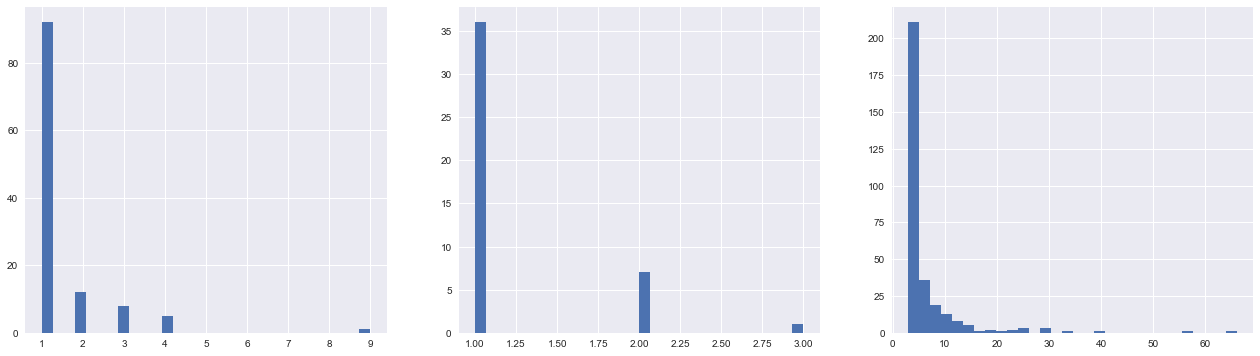

In [17]:
#visualising the distributions of Bookings Canceled, Bookings No Showed and Bookings Checked In for these customers
figure, axis = plt.subplots(1,3, figsize = (22,6))
axis[0].hist(dataset["BookingsCanceled"][dataset["BookingsCanceled"] > (3 * dataset["BookingsCanceled"].std() + dataset["BookingsCanceled"].mean())],30)
axis[1].hist(dataset["BookingsNoShowed"][dataset["BookingsNoShowed"] > (3 * dataset["BookingsNoShowed"].std() + dataset["BookingsNoShowed"].mean())],30)
axis[2].hist(dataset["BookingsCheckedIn"][dataset["BookingsCheckedIn"] > (3 * dataset["BookingsCheckedIn"].std() + dataset["BookingsCheckedIn"].mean())],30)
plt.show()

In [18]:
#customers with values below 0
print((dataset["LodgingRevenue"] < 0).value_counts())
print((dataset["OtherRevenue"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["LodgingRevenue"][dataset["LodgingRevenue"] > (3 * dataset["LodgingRevenue"].std() + dataset["LodgingRevenue"].mean())]))
print(len(dataset["OtherRevenue"][dataset["OtherRevenue"] > (3 * dataset["OtherRevenue"].std() + dataset["OtherRevenue"].mean())]))

False    83590
Name: LodgingRevenue, dtype: int64
False    83590
Name: OtherRevenue, dtype: int64
1364
1230


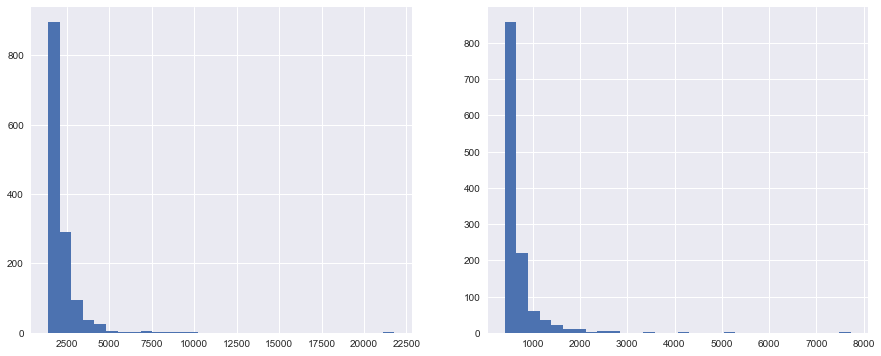

In [19]:
#visualising the distributions of Lodging Revenue and Other Revenue for these customers
figure, axis = plt.subplots(1,2, figsize = (15,6))
axis[0].hist(dataset["LodgingRevenue"][dataset["LodgingRevenue"] > (3 * dataset["LodgingRevenue"].std() + dataset["LodgingRevenue"].mean())],30)
axis[1].hist(dataset["OtherRevenue"][dataset["OtherRevenue"] > (3 * dataset["OtherRevenue"].std() + dataset["OtherRevenue"].mean())],30)
plt.show()

In [20]:
#customers with values below 0
print((dataset["RoomNights"] < 0).value_counts())
print((dataset["PersonsNights"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["RoomNights"][dataset["RoomNights"] > (3 * dataset["RoomNights"].std() + dataset["RoomNights"].mean())]))
print(len(dataset["PersonsNights"][dataset["PersonsNights"] > (3 * dataset["PersonsNights"].std() + dataset["PersonsNights"].mean())]))

False    83590
Name: RoomNights, dtype: int64
False    83590
Name: PersonsNights, dtype: int64
457
990


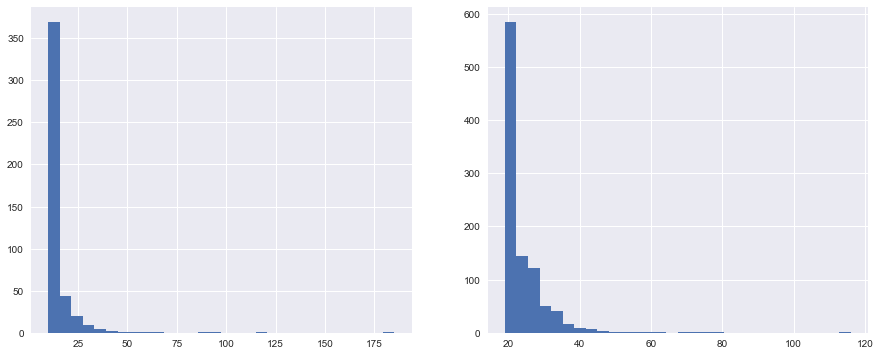

In [21]:
#visualising the distributions of Room Nights and Persons Nights for these customers
figure, axis = plt.subplots(1,2, figsize = (15,6))
axis[0].hist(dataset["RoomNights"][dataset["RoomNights"] > (3 * dataset["RoomNights"].std() + dataset["RoomNights"].mean())],30)
axis[1].hist(dataset["PersonsNights"][dataset["PersonsNights"] > (3 * dataset["PersonsNights"].std() + dataset["PersonsNights"].mean())],30)
plt.show()

In [22]:
#examining the DistributionChannel & MarketSegment -> earlier descriptive statistics showed all unique values for these variables which were all regular   

In [23]:
#examining all preference variables (booleans)
print((dataset[["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"]] < 0).value_counts())
print((dataset[["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"]] > 1).value_counts())

SRHighFloor  SRLowFloor  SRAccessibleRoom  SRMediumFloor  SRBathtub  SRShower  SRCrib  SRKingSizeBed  SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom
False        False       False             False          False      False     False   False          False      False           False               False                 False          83590
dtype: int64
SRHighFloor  SRLowFloor  SRAccessibleRoom  SRMediumFloor  SRBathtub  SRShower  SRCrib  SRKingSizeBed  SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom
False        False       False             False          False      False     False   False          False      False           False               False                 False          83590
dtype: int64


### Part 1.3: Feature Engineering
#### Part 1.3.1 Create a Continent Variable based on Nationality
The nationality variable has a large number of categories and most of these categories only include a very small number of customers. While target-based encoding would avoid the issue of having a large number of dummy variables it does not solve the issue of the imbalanced distribution of customers across the nationalities. Instead, the first solution will be to create a continent variable as this will be easier to represent using dummies and hopefully show a less imbalanced distribution. 
Unfortunately, creating said continent variable shows that the imbalance remains with the majority of customers coming (unsurprisingly) from Europe. Futhermore, among the customers coming from Europe there are still a large number of countries which are rarely represented. 
To make this variable that represents customers origin more useful for future analyses, the adjusted plan is as follows: represent countries outside of Europe by the continent they are in; for countries within Europe, summarise the less common ones under "OtherEurope". The criteria for which countries within Europe will remain, will be 1000 customers. As this new variable ("Origin") will still have a decent number of categories, the final step will be to use target-based encoding. As total revenue will be the target of the regression analysis, each category will be replaced by the group mean value of this category. 


In [24]:
#import a country and continent codes list
#https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5
url = "https://gist.githubusercontent.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c/raw/13716ceb2f22b5643ce5e7039643c86a0e0c6da6/country-and-continent-codes-list-csv.csv"
download = requests.get(url).content

country_continent_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
country_continent_df = country_continent_df[["Three_Letter_Country_Code", "Continent_Name"]]
country_continent_df.columns = ["Nationality", "Continent"]

In [25]:
#8 countries in this list are represented twice with different continents assigned, which results in issues when attempting to merge
#for these eight countries, the "duplicate" will be manually removed
#note: these decisions are not based on much consideration of the geopolitical/cutlural/.... situation of these countries, which would exceed the scope of this project
print(country_continent_df["Nationality"].value_counts()[country_continent_df["Nationality"].value_counts() > 1])

#Europe > Asia: Turkey, Armenia, Georgia, Azerbaijan
#Asia > Europe: Russia, Cyprus, Kazakhstan
#North America > Oceania: United States Minor Outlying Islands
country_continent_df = country_continent_df.drop(country_continent_df.index[[17, 235, 84, 9, 191, 58, 116, 171]])

#check that it worked
print(country_continent_df["Nationality"].value_counts()[country_continent_df["Nationality"].value_counts() > 1])

KAZ    2
CYP    2
RUS    2
AZE    2
UMI    2
GEO    2
ARM    2
TUR    2
Name: Nationality, dtype: int64
Series([], Name: Nationality, dtype: int64)


In [26]:
#create a contintent variable
dataset = pd.merge(dataset, country_continent_df[["Nationality", "Continent"]], how = "left", left_on = "Nationality", right_on = "Nationality")

In [38]:
top_nat = dataset["Nationality"][dataset["Continent"] == "Europe"].value_counts()[dataset["Nationality"][dataset["Continent"] == "Europe"].value_counts() > 1000].index.tolist()

In [50]:
(dataset["Nationality"].isin(top_nat) == False).value_counts()

False    63842
True     19748
Name: Nationality, dtype: int64

In [51]:
#create "Origin" variable based on Nationality and Continent
conditions = [(dataset["Continent"] == "Europe") & (dataset["Nationality"].isin(top_nat)),
    (dataset["Continent"] == "Europe") & (dataset["Nationality"].isin(top_nat) == False),
    (dataset["Continent"] != "Europe")]

values = [dataset["Nationality"], "Europe_Other", dataset["Continent"]]
dataset["Origin"] = np.select(conditions, values)

In [53]:
dataset["Origin"].value_counts()

FRA              12422
PRT              11597
DEU              10232
GBR               8656
Europe_Other      5797
North America     5237
ESP               4902
Asia              3675
South America     3378
ITA               3365
BEL               3119
NLD               2725
CHE               2108
IRL               1996
AUT               1489
SWE               1231
Oceania            834
Africa             813
Antarctica          13
Name: Origin, dtype: int64

In [57]:
#create the target variable of the regression analyses
dataset["TotalRevenue"] = dataset["OtherRevenue"] + dataset["LodgingRevenue"]

In [64]:
#create a TargetOrigin variable with the group mean for each Origin category 
dataset["TargetOrigin"] = dataset["Origin"].map(dataset.groupby("Origin")["TotalRevenue"].mean())
dataset[["Origin", "TotalRevenue"]].groupby("Origin").mean()

,TotalRevenue
Origin,
AUT,386.247649
Africa,489.026814
Antarctica,156.553846
Asia,342.155369
BEL,420.000529
CHE,388.707723
DEU,375.188045
ESP,366.330100
Europe_Other,422.990345


#### Part 1.3.2 Create Additional Variables
Firstly, as mentioned two now variables will be created based on the three Booking outcome variables. The first variable will be a categorical BookingsCheckedIn Variable with three categories: "None", "One", "More than One". The second variable will be a boolean NegativeOutcome variable with two categories: 1/True (has cancelled or not showed up at least once) and 0/False (never cancelled or no showed)

Secondly, the preference variables are all bool and could generally remain as they are. However, most of the could be considered unary variables. This leaves two options: (a) creating a variable to represent the total number of preferences/a bool to present whether they usually voice preferences or not, or (b) keeping only the most common preferences and summing up the uncommon ones into "SROther". To maintain as much information as possible, this latter option will be chosen. 

Thirdly, since the target variable is the Total Revenue, it does not make sense to maintain the LOding and Other Revenue Variables in the dataset. However, it could be interesting to keep the ratio between these two in the form of the proportion of income resulting from lodging. Consequently, this variable will be created as well. 

In [81]:
#categorical BookingsCheckedIn Variable 
conditions = [(dataset["BookingsCheckedIn"] == 0), (dataset["BookingsCheckedIn"] == 1), (dataset["BookingsCheckedIn"] > 1)]
values = ["None", "One", "More Than One"]

dataset["catBookingsCheckedIn"] = np.select(conditions, values)

In [ ]:
#boolean NegativeOutcome variable
#this variable is still almost unary, so it is unclear whether it will be useful at all for future analyses 
condition = ((dataset["BookingsNoShowed"] > 0) | (dataset["BookingsCanceled"] > 0))
dataset["NegativeOutcome"] = np.where(condition, 1, 0) 

In [87]:
#summary variable for preferences
#SRKingSizeBed, SRTwinBed, SRQuietRoom, and SRHighFloor will remain as they are. The remaining bool preferences will be summed up into one. 
condition = ( (dataset["SRLowFloor"] > 0) | (dataset["SRAccessibleRoom"] > 0) | (dataset["SRMediumFloor"] > 0) | (dataset["SRBathtub"] > 0) | (dataset["SRShower"] > 0) | (dataset["SRCrib"] > 0) | (dataset["SRNearElevator"] > 0) | (dataset["SRAwayFromElevator"] > 0) |  (dataset["SRNoAlcoholInMiniBar"] > 0) ) 
 	 	 	 	
dataset["OtherPreferences"] = np.where(condition, 1, 0)

In [114]:
#poportion of income from lodging variable
dataset["LodgingRevProp"] = (dataset["LodgingRevenue"]/dataset["TotalRevenue"]).fillna(0)

### Part 1.4 Exclusions & Final Touches
#### Part 1.4.1 Excluding Customers

In [127]:
#excluding customers with negative age or age above 100
regr_df = dataset[((dataset["Age"] >= 0) & (dataset["Age"] < 100)) | (dataset["Age"].isna())]

#excluding customers where lodging revenue is above 5000 or other revenue is above 2000
regr_df = regr_df[(regr_df["LodgingRevenue"] < 5000) & (regr_df["OtherRevenue"] < 2000)]

#excluding customers with RoomNights above 30 or PersonNights above 40
regr_df = regr_df[(regr_df["RoomNights"] < 30) & (regr_df["PersonsNights"] < 40)]

#exclude customers from Antarctica
regr_df = regr_df[(regr_df["Origin"] != "Antarctica")]

#### Part 1.4.2 Excluding Columns

In [136]:
regr_df = regr_df.drop(["ID", "NameHash", "DocIDHash", "BookingsCheckedIn", "BookingsCanceled", "BookingsNoShowed", "Nationality", "Continent", "LodgingRevenue", "OtherRevenue", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", 	"SRBathtub", "SRShower", "SRCrib", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "Origin"], axis = 1)

#### Part 1.4.3: Normalistions?
While the quantitative variables in this dataset were certainly not all perfectly normally disrtributed and instead often showed a skew to the right due to extreme outliers, due to the size of the dataset and the approximation of a ND, no quantitative variables will be transformed. 

#### Part 1.4.4: Train-Test Split
- split data into train and test

#### Part 1.4.5: Fill in Missing Values
- filling in missing values for age and average lead using a kNN model fitted on the train set

## Part 2: Regression Analyses
- building a pipeline: scaling & dummy encoding (via columntransformer) + model
    - need to be scaled: Age, AverageLeadTime, DaysSinceCreation, DaysSinceLastStay, DaysSinceFirstStay, RoomNights, PersonsNights (maxmin probably)
        - need to consider that DaysSinceLastStay & DaysSinceFirstStay use -1 to represent customers that never completed a booking
    - need to be encoded: catBookingsCheckedIn, DistributionChannel, MarketSegment
- apply grid search & cv


Secondly, dummy variables will be created for three variables: catBookingsCheckedIn, DistributionChannel, and MarketSegment. Based on my statistical background, k - 1 dummies will be created for a variable with k categories. 